In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import os
import time
import warnings
warnings.filterwarnings('ignore')

from sklearn.metrics import precision_recall_curve, average_precision_score

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import VotingClassifier


from sklearn.model_selection import cross_val_score, StratifiedKFold, cross_val_predict
from sklearn.metrics import (roc_auc_score, accuracy_score, precision_score, 
                             recall_score, f1_score, confusion_matrix, 
                             classification_report, roc_curve)

from skopt import BayesSearchCV
from skopt.space import Real, Categorical, Integer

%matplotlib inline

In [ ]:
data_dir = "../data/processed/"

X_train = np.load(f"{data_dir}X_train.npy")
X_test = np.load(f"{data_dir}X_test.npy")
y_train = np.load(f"{data_dir}y_train.npy")
y_test = np.load(f"{data_dir}y_test.npy")

with open(f"{data_dir}feature_names.txt", 'r') as f:
    feature_names = [line.strip() for line in f.readlines()]

print(f"Shape dos dados de treino: {X_train.shape}")
print(f"Shape dos dados de teste: {X_test.shape}")
print(f"\nDistribuição do target no treino:")
print(f"  Classe 0 (Não-conversor): {(y_train == 0).sum()} ({(y_train == 0).sum()/len(y_train)*100:.1f}%)")
print(f"  Classe 1 (Conversor): {(y_train == 1).sum()} ({(y_train == 1).sum()/len(y_train)*100:.1f}%)")
print(f"\nNúmero de features: {len(feature_names)}")

Shape dos dados de treino: (472, 27)
Shape dos dados de teste: (119, 27)

Distribuição do target no treino:
  Classe 0 (Não-conversor): 319 (67.6%)
  Classe 1 (Conversor): 153 (32.4%)

Número de features: 27


## 2. Configurar validação cruzada

Vou usar 10-fold stratified cross-validation para avaliar os modelos de forma mais robusta.

In [ ]:
cv_strategy = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

print(f"Estratégia de validação: 10-fold Stratified Cross-Validation")

Estratégia de validação: 10-fold Stratified Cross-Validation
Métrica principal: ROC-AUC (boa para dados desbalanceados)




Modelos:
- **Logistic Regression**, **Naive Bayes**, **Random Forest**

In [ ]:

models_config = {
    'Logistic Regression': {
        'estimator': LogisticRegression(max_iter=1000, random_state=42, class_weight='balanced'),
        'search_spaces': {
            'C': Real(0.001, 100, prior='log-uniform'),  
            'penalty': Categorical(['l1', 'l2', 'elasticnet']),
            'solver': Categorical(['saga']),  
            'l1_ratio': Real(0.0, 1.0)  
        }
    },
    
    'Naive Bayes': {
        'estimator': GaussianNB(),
        'search_spaces': {}  
    },
    
    'Random Forest': {
        'estimator': RandomForestClassifier(random_state=42, class_weight='balanced', n_jobs=-1),
        'search_spaces': {
            'n_estimators': Integer(100, 1000),  
            'max_depth': Integer(5, 30),  
            'min_samples_split': Integer(2, 20), 
            'min_samples_leaf': Integer(1, 10), 
            'max_features': Categorical(['sqrt', 'log2', None])  
        }
    },
    
    'SVM RBF': {
        'estimator': SVC(kernel='rbf', probability=True, random_state=42, class_weight='balanced'),
        'search_spaces': {
            'C': Real(0.1, 100, prior='log-uniform'), 
            'gamma': Real(0.0001, 1, prior='log-uniform')  
        }
    }
}

print(f"Total de modelos a treinar: {len(models_config)}")
for nome in models_config.keys():
    print(f"  - {nome}")
    if models_config[nome]['search_spaces']:
        print(f"    Hiperparâmetros a otimizar: {list(models_config[nome]['search_spaces'].keys())}")

Total de modelos a treinar: 4
  - Logistic Regression
    Hiperparâmetros a otimizar: ['C', 'penalty', 'solver', 'l1_ratio']
  - Naive Bayes
  - Random Forest
    Hiperparâmetros a otimizar: ['n_estimators', 'max_depth', 'min_samples_split', 'min_samples_leaf', 'max_features']
  - SVM RBF
    Hiperparâmetros a otimizar: ['C', 'gamma']


## 4. Otimizar e treinar cada modelo

Agora vou usar **BayesSearchCV** pra encontrar os melhores hiperparâmetros automaticamente. 

Ele testa diferentes combinações de forma inteligente (não aleatória) pra maximizar o ROC-AUC.Vou fazer 40 iterações por modelo com 10-fold CV em cada uma.


In [ ]:
results = {
    'Model': [],
    'ROC-AUC_mean': [],
    'ROC-AUC_std': [],
    'Accuracy_mean': [],
    'Accuracy_std': [],
    'Precision_mean': [],
    'Recall_mean': [],
    'F1_mean': [],
    'Best_params': [],
    'Training_time': []
}

trained_models = {}
optimization_results = {}  

for model_name, config in models_config.items():
    
    start_time = time.time()
    
    if not config['search_spaces']:
        
        model = config['estimator']
        
        roc_auc_scores = cross_val_score(model, X_train, y_train, cv=cv_strategy, scoring='roc_auc', n_jobs=-1)
        acc_scores = cross_val_score(model, X_train, y_train, cv=cv_strategy, scoring='accuracy', n_jobs=-1)
        precision_scores = cross_val_score(model, X_train, y_train, cv=cv_strategy, scoring='precision', n_jobs=-1)
        recall_scores = cross_val_score(model, X_train, y_train, cv=cv_strategy, scoring='recall', n_jobs=-1)
        f1_scores = cross_val_score(model, X_train, y_train, cv=cv_strategy, scoring='f1', n_jobs=-1)
        
        model.fit(X_train, y_train)
        trained_models[model_name] = model
        best_params = "N/A"
        
    else:
        print(f"Espaço de busca: {config['search_spaces']}")
        
        bayes_search = BayesSearchCV(
            estimator=config['estimator'],
            search_spaces=config['search_spaces'],
            n_iter=40,  
            cv=cv_strategy,
            scoring='roc_auc',
            n_jobs=-1,
            random_state=42,
            verbose=0,
            n_points=3, 
            return_train_score=True
        )
        
        bayes_search.fit(X_train, y_train)
        
        best_model = bayes_search.best_estimator_
        best_params = bayes_search.best_params_
        
        roc_auc_scores = cross_val_score(best_model, X_train, y_train, cv=cv_strategy, scoring='roc_auc', n_jobs=-1)
        acc_scores = cross_val_score(best_model, X_train, y_train, cv=cv_strategy, scoring='accuracy', n_jobs=-1)
        precision_scores = cross_val_score(best_model, X_train, y_train, cv=cv_strategy, scoring='precision', n_jobs=-1)
        recall_scores = cross_val_score(best_model, X_train, y_train, cv=cv_strategy, scoring='recall', n_jobs=-1)
        f1_scores = cross_val_score(best_model, X_train, y_train, cv=cv_strategy, scoring='f1', n_jobs=-1)
        
        trained_models[model_name] = best_model
        optimization_results[model_name] = bayes_search
        
        print(f"Melhores hiperparâmetros encontrados:")
        for param, value in best_params.items():
            print(f"  {param}: {value}")
    
    training_time = time.time() - start_time
    
    results['Model'].append(model_name)
    results['ROC-AUC_mean'].append(roc_auc_scores.mean())
    results['ROC-AUC_std'].append(roc_auc_scores.std())
    results['Accuracy_mean'].append(acc_scores.mean())
    results['Accuracy_std'].append(acc_scores.std())
    results['Precision_mean'].append(precision_scores.mean())
    results['Recall_mean'].append(recall_scores.mean())
    results['F1_mean'].append(f1_scores.mean())
    results['Best_params'].append(str(best_params))
    results['Training_time'].append(training_time)
    
    print(f"\nResultados com melhor configuração 10-fold :")
    print(f"  ROC-AUC:   {roc_auc_scores.mean():.4f} (±{roc_auc_scores.std():.4f})")
    print(f"  Accuracy:  {acc_scores.mean():.4f} (±{acc_scores.std():.4f})")
    print(f"  Precision: {precision_scores.mean():.4f}")
    print(f"  Recall:    {recall_scores.mean():.4f}")
    print(f"  F1-Score:  {f1_scores.mean():.4f}")
    print(f"  Tempo:     {training_time:.1f}s")




Otimizando: Logistic Regression
Iniciando Bayesian Optimization...
Espaço de busca: {'C': Real(low=0.001, high=100, prior='log-uniform', transform='identity'), 'penalty': Categorical(categories=('l1', 'l2', 'elasticnet'), prior=None), 'solver': Categorical(categories=('saga',), prior=None), 'l1_ratio': Real(low=0.0, high=1.0, prior='uniform', transform='identity')}

✓ Otimização concluída!
Melhores hiperparâmetros encontrados:
  C: 0.11233621690895233
  l1_ratio: 0.7277257431773251
  penalty: elasticnet
  solver: saga

Resultados com melhor configuração (10-fold CV):
  ROC-AUC:   0.9135 (±0.0270)
  Accuracy:  0.8199 (±0.0454)
  Precision: 0.6957
  Recall:    0.8042
  F1-Score:  0.7433
  Tempo:     30.7s

Otimizando: Naive Bayes
Sem hiperparâmetros para otimizar. Treinando modelo padrão...

Resultados com melhor configuração (10-fold CV):
  ROC-AUC:   0.8905 (±0.0272)
  Accuracy:  0.7776 (±0.0367)
  Precision: 0.6382
  Recall:    0.7388
  F1-Score:  0.6817
  Tempo:     0.1s

Otimizando

In [78]:
results_df = pd.DataFrame(results).sort_values('ROC-AUC_mean', ascending=False).reset_index(drop=True)

print(results_df.to_string(index=False))


              Model  ROC-AUC_mean  ROC-AUC_std  Accuracy_mean  Accuracy_std  Precision_mean  Recall_mean  F1_mean                                                                                                              Best_params  Training_time
Logistic Regression      0.913490     0.027037       0.819902      0.045404        0.695709     0.804167 0.743321       OrderedDict({'C': 0.11233621690895233, 'l1_ratio': 0.7277257431773251, 'penalty': 'elasticnet', 'solver': 'saga'})      30.702520
            SVM RBF      0.913346     0.027928       0.805009      0.045450        0.665578     0.817083 0.730879                                                     OrderedDict({'C': 1.597605909365623, 'gamma': 0.003846070999406944})      21.650750
      Random Forest      0.911792     0.026705       0.836879      0.034052        0.782306     0.700000 0.732894 OrderedDict({'max_depth': 17, 'max_features': None, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 493})     285.213832


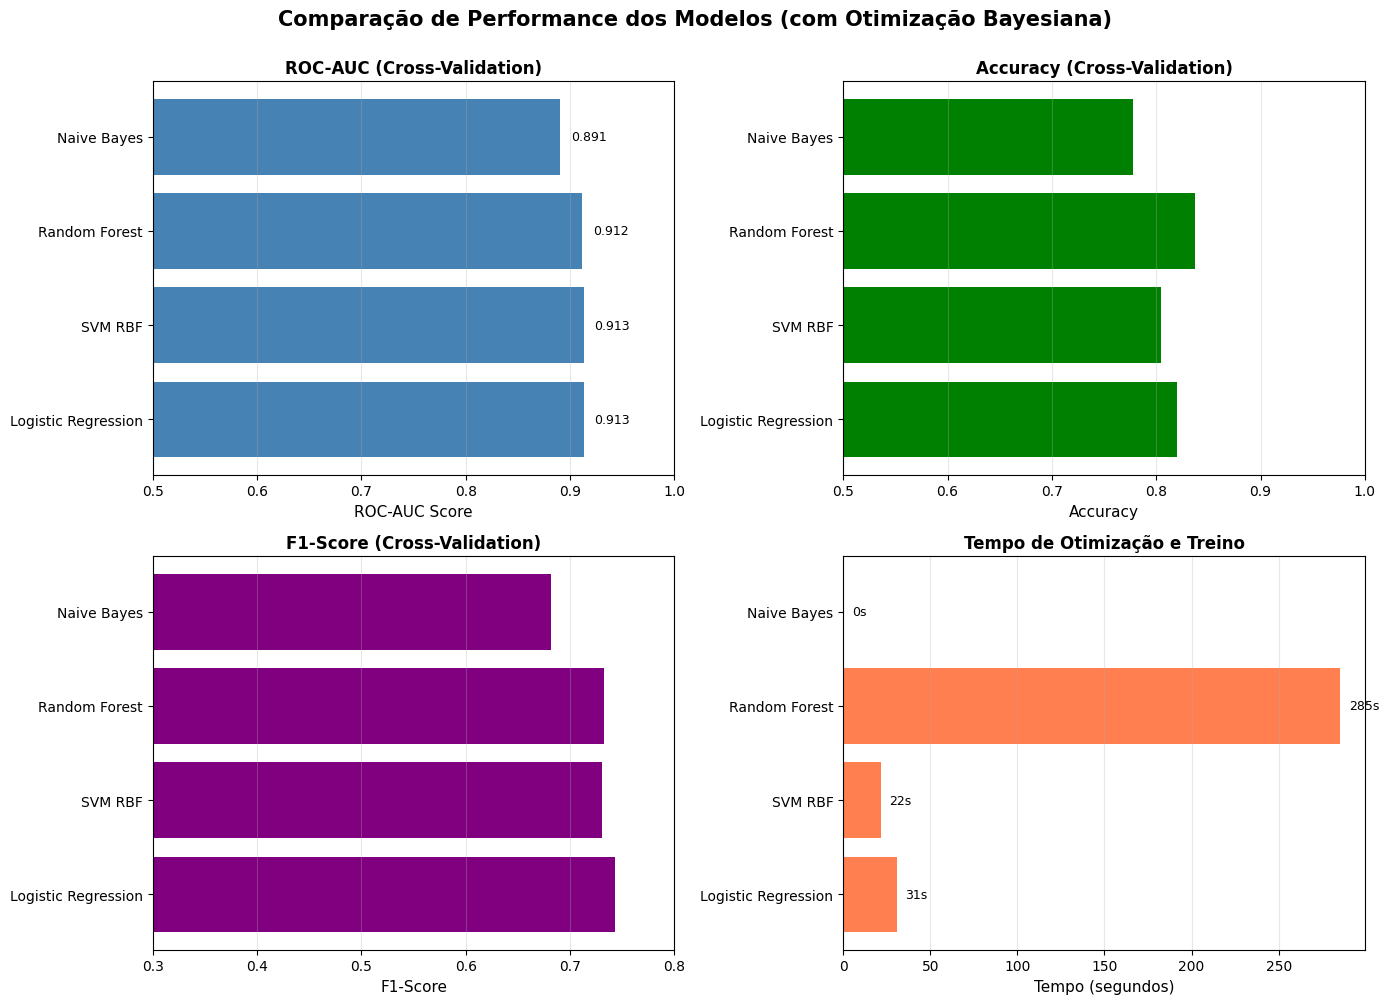

In [ ]:
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

axes[0, 0].barh(results_df['Model'], results_df['ROC-AUC_mean'], color='steelblue')
axes[0, 0].set_xlabel('ROC-AUC Score', fontsize=11)
axes[0, 0].set_title('ROC-AUC (Cross-Validation)', fontweight='bold', fontsize=12)
axes[0, 0].set_xlim([0.5, 1.0])
axes[0, 0].grid(axis='x', alpha=0.3)
for i, (idx, row) in enumerate(results_df.iterrows()):
    axes[0, 0].text(row['ROC-AUC_mean'] + 0.01, i, f"{row['ROC-AUC_mean']:.3f}", 
                    va='center', fontsize=9)

axes[0, 1].barh(results_df['Model'], results_df['Accuracy_mean'], color='green')
axes[0, 1].set_xlabel('Accuracy', fontsize=11)
axes[0, 1].set_title('Accuracy (Cross-Validation)', fontweight='bold', fontsize=12)
axes[0, 1].set_xlim([0.5, 1.0])
axes[0, 1].grid(axis='x', alpha=0.3)

axes[1, 0].barh(results_df['Model'], results_df['F1_mean'], color='purple')
axes[1, 0].set_xlabel('F1-Score', fontsize=11)
axes[1, 0].set_title('F1-Score (Cross-Validation)', fontweight='bold', fontsize=12)
axes[1, 0].set_xlim([0.3, 0.8])
axes[1, 0].grid(axis='x', alpha=0.3)

axes[1, 1].barh(results_df['Model'], results_df['Training_time'], color='coral')
axes[1, 1].set_xlabel('Tempo (segundos)', fontsize=11)
axes[1, 1].set_title('Tempo de Otimização e Treino', fontweight='bold', fontsize=12)
axes[1, 1].grid(axis='x', alpha=0.3)
for i, (idx, row) in enumerate(results_df.iterrows()):
    axes[1, 1].text(row['Training_time'] + 5, i, f"{row['Training_time']:.0f}s", 
                    va='center', fontsize=9)

plt.suptitle('Comparação de Performance dos Modelos', fontsize=15, fontweight='bold', y=1.00)
plt.tight_layout()
plt.show()


Agora vou ver como o melhor modelo se sai nos dados de teste que ele nunca viu.

In [ ]:
best_model = trained_models[results_df['Model'].iloc[0]]

print(f"Melhor modelo (baseado em ROC-AUC CV): {results_df['Model'].iloc[0]}")
print(f"ROC-AUC CV: {results_df['ROC-AUC_mean'].iloc[0]:.4f}")

if results_df['Model'].iloc[0] in optimization_results:
    print(f"\nHiperparâmetros otimizados:")
    for param, value in optimization_results[results_df['Model'].iloc[0]].best_params_.items():
        print(f"  {param}: {value}")


y_pred_proba = best_model.predict_proba(X_test)[:, 1]
y_pred = best_model.predict(X_test)

test_roc_auc = roc_auc_score(y_test, y_pred_proba)
test_accuracy = accuracy_score(y_test, y_pred)
test_precision = precision_score(y_test, y_pred)
test_recall = recall_score(y_test, y_pred)
test_f1 = f1_score(y_test, y_pred)

print(f"\nMétricas no Teste:")
print(f"  ROC-AUC:   {test_roc_auc:.4f}")
print(f"  Accuracy:  {test_accuracy:.4f}")
print(f"  Precision: {test_precision:.4f}")
print(f"  Recall:    {test_recall:.4f}")
print(f"  F1-Score:  {test_f1:.4f}")

cm = confusion_matrix(y_test, y_pred)
print(f"\nMatriz de Confusão:")
print(f"                  Predito")
print(f"                  Não-Conv  Conversor")
print(f"Real Não-Conv      {cm[0,0]:4d}      {cm[0,1]:4d}")
print(f"Real Conversor     {cm[1,0]:4d}      {cm[1,1]:4d}")

tn, fp, fn, tp = cm.ravel()
sensitivity = tp / (tp + fn)  
specificity = tn / (tn + fp)  
ppv = tp / (tp + fp) if (tp + fp) > 0 else 0  
npv = tn / (tn + fn) if (tn + fn) > 0 else 0  
balanced_acc = (sensitivity + specificity) / 2

print(f"  Sensitivity (Recall):     {sensitivity:.4f}  ")
print(f"  Specificity:              {specificity:.4f}  ")
print(f"  PPV (Precision):          {ppv:.4f}  ")
print(f"  NPV:                      {npv:.4f}  ")
print(f"  Balanced Accuracy:        {balanced_acc:.4f}")

Melhor modelo (baseado em ROC-AUC CV): Logistic Regression
ROC-AUC CV: 0.9135

Hiperparâmetros otimizados:
  C: 0.11233621690895233
  l1_ratio: 0.7277257431773251
  penalty: elasticnet
  solver: saga

AVALIAÇÃO NO CONJUNTO DE TESTE

Métricas no Teste:
  ROC-AUC:   0.8692
  Accuracy:  0.7647
  Precision: 0.6170
  Recall:    0.7436
  F1-Score:  0.6744

Matriz de Confusão:
                  Predito
                  Não-Conv  Conversor
Real Não-Conv        62        18
Real Conversor       10        29

Métricas Clínicas (importantes pra medicina):
  Sensitivity (Recall):     0.7436  (detectar quem vai converter)
  Specificity:              0.7750  (detectar quem NÃO vai converter)
  PPV (Precision):          0.6170  (se predisse conversor, chance de estar certo)
  NPV:                      0.8611  (se predisse não-conversor, chance de estar certo)
  Balanced Accuracy:        0.7593


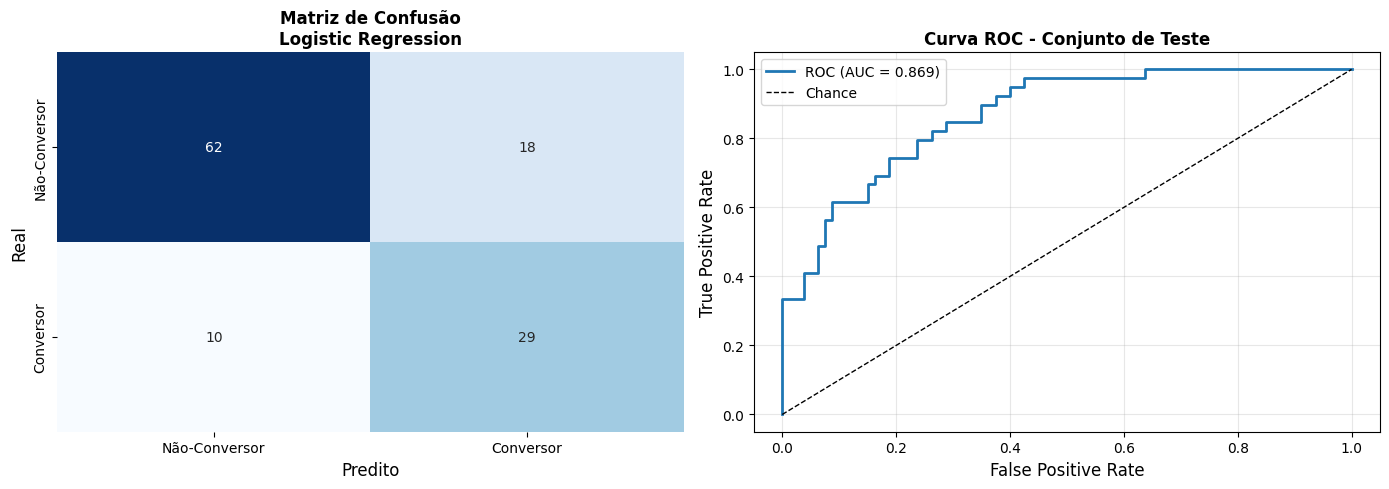

In [80]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Não-Conversor', 'Conversor'],
            yticklabels=['Não-Conversor', 'Conversor'],
            ax=axes[0], cbar=False)
axes[0].set_ylabel('Real', fontsize=12)
axes[0].set_xlabel('Predito', fontsize=12)
axes[0].set_title(f'Matriz de Confusão\n{results_df["Model"].iloc[0]}', fontweight='bold', fontsize=12)

fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
axes[1].plot(fpr, tpr, linewidth=2, label=f'ROC (AUC = {test_roc_auc:.3f})')
axes[1].plot([0, 1], [0, 1], 'k--', linewidth=1, label='Chance')
axes[1].set_xlabel('False Positive Rate', fontsize=12)
axes[1].set_ylabel('True Positive Rate', fontsize=12)
axes[1].set_title('Curva ROC - Conjunto de Teste', fontweight='bold', fontsize=12)
axes[1].legend(fontsize=10)
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

Vou testar vários thresholds e ver o impacto nas métricas clínicas.

In [ ]:
thresholds_to_test = [0.3, 0.4, 0.5, 0.6, 0.7, 0.8]

print("ANÁLISE DE THRESHOLDS PARA APLICAÇÕES CLÍNICAS")
print("="*80)
print("\nTestando diferentes thresholds de decisão...\n")

threshold_results = []

for threshold in thresholds_to_test:
    y_pred_threshold = (y_pred_proba >= threshold).astype(int)
    
    cm_thresh = confusion_matrix(y_test, y_pred_threshold)
    tn, fp, fn, tp = cm_thresh.ravel()
    
    sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0
    specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
    ppv = tp / (tp + fp) if (tp + fp) > 0 else 0
    npv = tn / (tn + fn) if (tn + fn) > 0 else 0
    accuracy = (tp + tn) / (tp + tn + fp + fn)
    f1 = 2 * (ppv * sensitivity) / (ppv + sensitivity) if (ppv + sensitivity) > 0 else 0
    balanced_acc = (sensitivity + specificity) / 2
    
    threshold_results.append({
        'Threshold': threshold,
        'Sensitivity': sensitivity,
        'Specificity': specificity,
        'PPV': ppv,
        'NPV': npv,
        'Accuracy': accuracy,
        'F1-Score': f1,
        'Balanced_Acc': balanced_acc,
        'TP': tp,
        'TN': tn,
        'FP': fp,
        'FN': fn
    })

threshold_df = pd.DataFrame(threshold_results)

print("Impacto dos Thresholds nas Métricas Clínicas:")
print(threshold_df[['Threshold', 'Sensitivity', 'Specificity', 'PPV', 'NPV', 
                    'Accuracy', 'F1-Score', 'Balanced_Acc']].to_string(index=False))


ANÁLISE DE THRESHOLDS PARA APLICAÇÕES CLÍNICAS

Testando diferentes thresholds de decisão...

Impacto dos Thresholds nas Métricas Clínicas:
 Threshold  Sensitivity  Specificity      PPV      NPV  Accuracy  F1-Score  Balanced_Acc
       0.3     0.923077       0.6125 0.537313 0.942308  0.714286  0.679245      0.767788
       0.4     0.846154       0.7000 0.578947 0.903226  0.747899  0.687500      0.773077
       0.5     0.743590       0.7750 0.617021 0.861111  0.764706  0.674419      0.759295
       0.6     0.615385       0.8625 0.685714 0.821429  0.781513  0.648649      0.738942
       0.7     0.564103       0.9250 0.785714 0.813187  0.806723  0.656716      0.744551
       0.8     0.410256       0.9500 0.800000 0.767677  0.773109  0.542373      0.680128



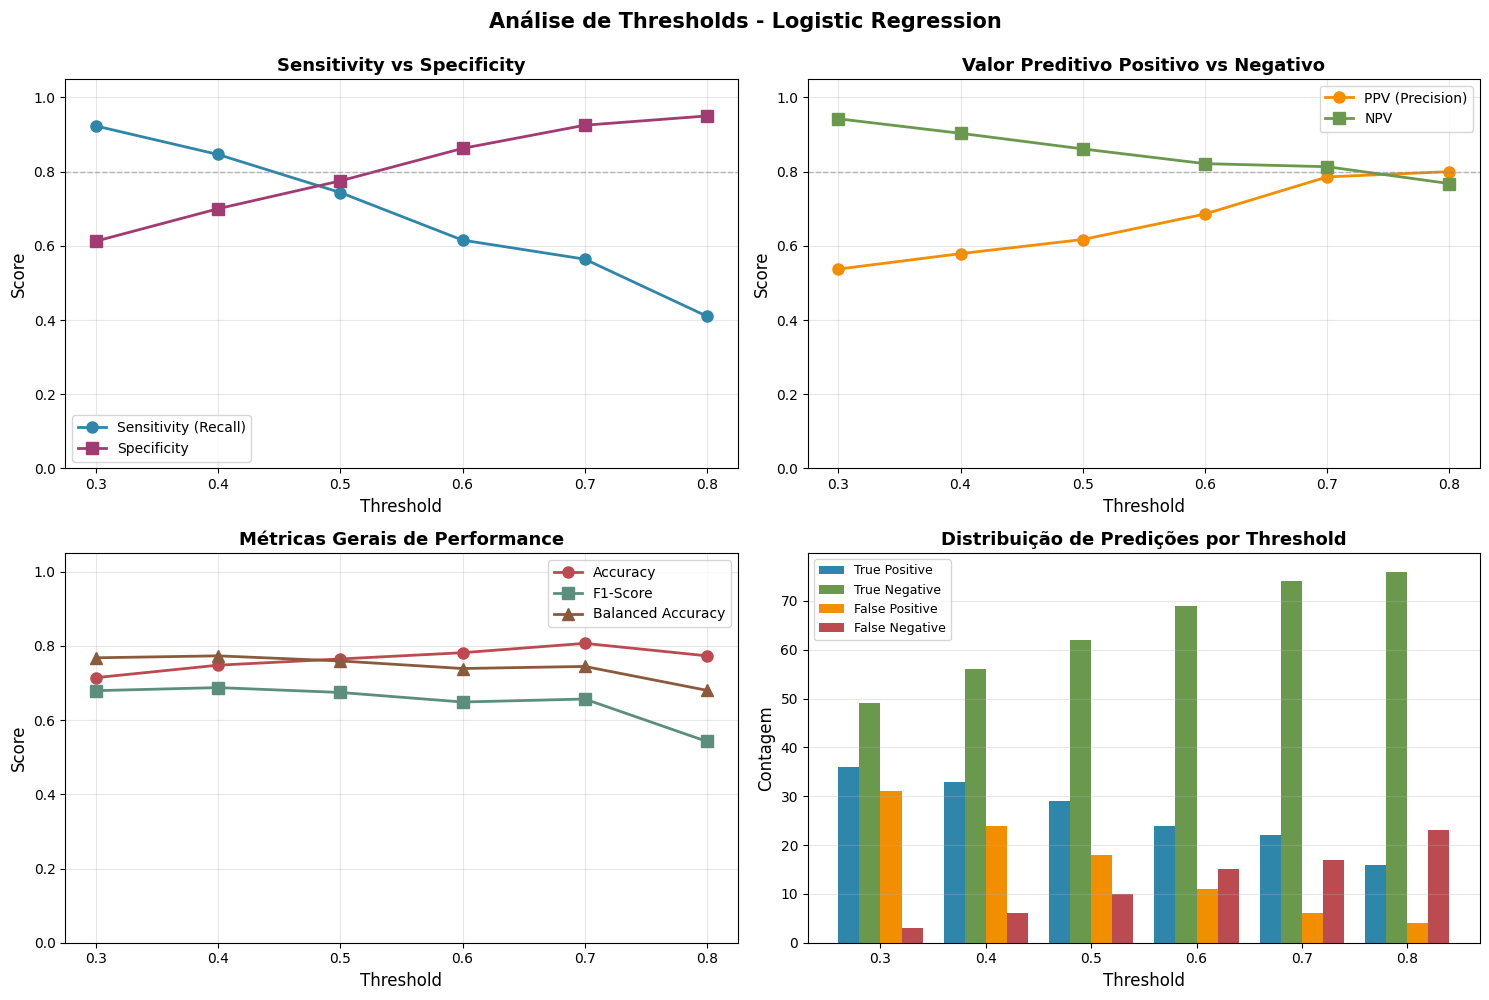

In [ ]:
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

ax1 = axes[0, 0]
ax1.plot(threshold_df['Threshold'], threshold_df['Sensitivity'], 'o-', 
         linewidth=2, markersize=8, label='Sensitivity (Recall)', color='#2E86AB')
ax1.plot(threshold_df['Threshold'], threshold_df['Specificity'], 's-', 
         linewidth=2, markersize=8, label='Specificity', color='#A23B72')
ax1.axhline(y=0.8, color='gray', linestyle='--', alpha=0.5, linewidth=1)
ax1.set_xlabel('Threshold', fontsize=12)
ax1.set_ylabel('Score', fontsize=12)
ax1.set_title('Sensitivity vs Specificity', fontweight='bold', fontsize=13)
ax1.legend(fontsize=10)
ax1.grid(alpha=0.3)
ax1.set_ylim([0, 1.05])

ax2 = axes[0, 1]
ax2.plot(threshold_df['Threshold'], threshold_df['PPV'], 'o-', 
         linewidth=2, markersize=8, label='PPV (Precision)', color='#F18F01')
ax2.plot(threshold_df['Threshold'], threshold_df['NPV'], 's-', 
         linewidth=2, markersize=8, label='NPV', color='#6A994E')
ax2.axhline(y=0.8, color='gray', linestyle='--', alpha=0.5, linewidth=1)
ax2.set_xlabel('Threshold', fontsize=12)
ax2.set_ylabel('Score', fontsize=12)
ax2.set_title('Valor Preditivo Positivo vs Negativo', fontweight='bold', fontsize=13)
ax2.legend(fontsize=10)
ax2.grid(alpha=0.3)
ax2.set_ylim([0, 1.05])

ax3 = axes[1, 0]
ax3.plot(threshold_df['Threshold'], threshold_df['Accuracy'], 'o-', 
         linewidth=2, markersize=8, label='Accuracy', color='#BC4B51')
ax3.plot(threshold_df['Threshold'], threshold_df['F1-Score'], 's-', 
         linewidth=2, markersize=8, label='F1-Score', color='#5B8E7D')
ax3.plot(threshold_df['Threshold'], threshold_df['Balanced_Acc'], '^-', 
         linewidth=2, markersize=8, label='Balanced Accuracy', color='#8B5A3C')
ax3.set_xlabel('Threshold', fontsize=12)
ax3.set_ylabel('Score', fontsize=12)
ax3.set_title('Métricas Gerais de Performance', fontweight='bold', fontsize=13)
ax3.legend(fontsize=10)
ax3.grid(alpha=0.3)
ax3.set_ylim([0, 1.05])

ax4 = axes[1, 1]
x_pos = np.arange(len(thresholds_to_test))
width = 0.2

ax4.bar(x_pos - 1.5*width, threshold_df['TP'], width, label='True Positive', color='#2E86AB')
ax4.bar(x_pos - 0.5*width, threshold_df['TN'], width, label='True Negative', color='#6A994E')
ax4.bar(x_pos + 0.5*width, threshold_df['FP'], width, label='False Positive', color='#F18F01')
ax4.bar(x_pos + 1.5*width, threshold_df['FN'], width, label='False Negative', color='#BC4B51')

ax4.set_xlabel('Threshold', fontsize=12)
ax4.set_ylabel('Contagem', fontsize=12)
ax4.set_title('Distribuição de Predições por Threshold', fontweight='bold', fontsize=13)
ax4.set_xticks(x_pos)
ax4.set_xticklabels(thresholds_to_test)
ax4.legend(fontsize=9)
ax4.grid(axis='y', alpha=0.3)

plt.suptitle(f'Análise de Thresholds - {results_df["Model"].iloc[0]}', 
             fontsize=15, fontweight='bold', y=0.995)
plt.tight_layout()
plt.show()

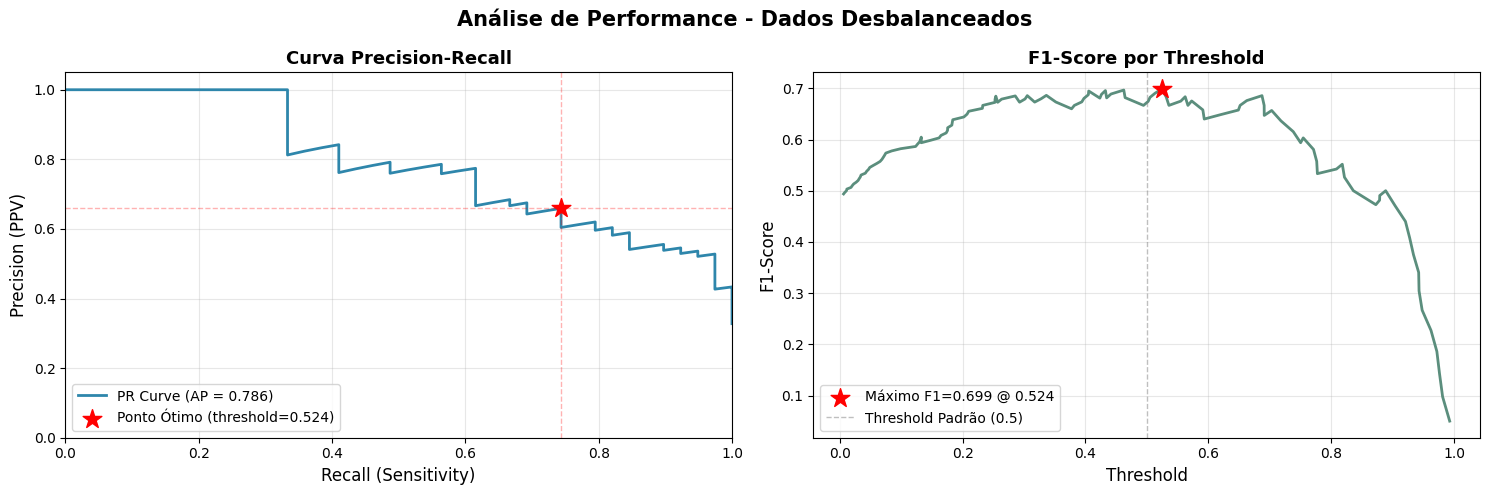


THRESHOLD ÓTIMO (maximiza F1-Score)
Threshold ótimo: 0.524
  F1-Score:      0.6988
  Precision:     0.6591
  Recall:        0.7436


In [ ]:

precision_curve, recall_curve, thresholds_pr = precision_recall_curve(y_test, y_pred_proba)
avg_precision = average_precision_score(y_test, y_pred_proba)

f1_scores = 2 * (precision_curve * recall_curve) / (precision_curve + recall_curve + 1e-10)
optimal_idx = np.argmax(f1_scores[:-1])  
optimal_threshold = thresholds_pr[optimal_idx]
optimal_precision = precision_curve[optimal_idx]
optimal_recall = recall_curve[optimal_idx]
optimal_f1 = f1_scores[optimal_idx]

fig, axes = plt.subplots(1, 2, figsize=(15, 5))

axes[0].plot(recall_curve, precision_curve, linewidth=2, 
             label=f'PR Curve (AP = {avg_precision:.3f})', color='#2E86AB')
axes[0].scatter([optimal_recall], [optimal_precision], s=200, 
                color='red', marker='*', zorder=5, 
                label=f'Ponto Ótimo (threshold={optimal_threshold:.3f})')
axes[0].axhline(y=optimal_precision, color='red', linestyle='--', alpha=0.3, linewidth=1)
axes[0].axvline(x=optimal_recall, color='red', linestyle='--', alpha=0.3, linewidth=1)
axes[0].set_xlabel('Recall (Sensitivity)', fontsize=12)
axes[0].set_ylabel('Precision (PPV)', fontsize=12)
axes[0].set_title('Curva Precision-Recall', fontweight='bold', fontsize=13)
axes[0].legend(fontsize=10)
axes[0].grid(alpha=0.3)
axes[0].set_xlim([0, 1])
axes[0].set_ylim([0, 1.05])

axes[1].plot(thresholds_pr, f1_scores[:-1], linewidth=2, color='#5B8E7D')
axes[1].scatter([optimal_threshold], [optimal_f1], s=200, 
                color='red', marker='*', zorder=5,
                label=f'Máximo F1={optimal_f1:.3f} @ {optimal_threshold:.3f}')
axes[1].axvline(x=0.5, color='gray', linestyle='--', alpha=0.5, linewidth=1,
                label='Threshold Padrão (0.5)')
axes[1].set_xlabel('Threshold', fontsize=12)
axes[1].set_ylabel('F1-Score', fontsize=12)
axes[1].set_title('F1-Score por Threshold', fontweight='bold', fontsize=13)
axes[1].legend(fontsize=10)
axes[1].grid(alpha=0.3)

plt.suptitle('Análise de Performance - Dados Desbalanceados', 
             fontsize=15, fontweight='bold')
plt.tight_layout()
plt.show()

print("THRESHOLD ÓTIMO ")
print(f"Threshold ótimo: {optimal_threshold:.3f}")
print(f"  F1-Score:      {optimal_f1:.4f}")
print(f"  Precision:     {optimal_precision:.4f}")
print(f"  Recall:        {optimal_recall:.4f}")

In [ ]:

screening_candidates = threshold_df[threshold_df['Sensitivity'] >= 0.85]
if len(screening_candidates) > 0:
    screening_thresh = screening_candidates.iloc[0]['Threshold']
    screening_row = screening_candidates.iloc[0]
else:
    screening_idx = threshold_df['Sensitivity'].idxmax()
    screening_thresh = threshold_df.loc[screening_idx, 'Threshold']
    screening_row = threshold_df.loc[screening_idx]

print("\n  TRIAGEM/SCREENING ")
print(f"   Threshold recomendado: {screening_thresh:.2f}")
print(f"   Sensitivity: {screening_row['Sensitivity']:.4f} (detecta {screening_row['Sensitivity']*100:.1f}% dos conversores)")
print(f"   Specificity: {screening_row['Specificity']:.4f}")
print(f"   PPV:         {screening_row['PPV']:.4f}")
print(f"   NPV:         {screening_row['NPV']:.4f}")
print(f"   → Ideal para: Triagem inicial, identificar pacientes para acompanhamento")
print(f"   → Trade-off: Mais falsos positivos ({int(screening_row['FP'])} casos), mas minimiza casos perdidos")

optimal_row = threshold_df.iloc[(threshold_df['Threshold'] - optimal_threshold).abs().argmin()]
print(f"\n  DECISÃO CLÍNICA BALANCEADA ")
print(f"   Threshold recomendado: {optimal_threshold:.2f}")
print(f"   Sensitivity: {optimal_row['Sensitivity']:.4f}")
print(f"   Specificity: {optimal_row['Specificity']:.4f}")
print(f"   PPV:         {optimal_row['PPV']:.4f}")
print(f"   NPV:         {optimal_row['NPV']:.4f}")
print(f"   F1-Score:    {optimal_row['F1-Score']:.4f}")

confirmation_candidates = threshold_df[threshold_df['Specificity'] >= 0.85]
if len(confirmation_candidates) > 0:
    confirmation_idx = confirmation_candidates['PPV'].idxmax()
    confirmation_thresh = confirmation_candidates.loc[confirmation_idx, 'Threshold']
    confirmation_row = confirmation_candidates.loc[confirmation_idx]
else:
    confirmation_idx = threshold_df['Specificity'].idxmax()
    confirmation_thresh = threshold_df.loc[confirmation_idx, 'Threshold']
    confirmation_row = threshold_df.loc[confirmation_idx]

print(f"\n  CONFIRMAÇÃO DIAGNÓSTICA ")
print(f"   Threshold recomendado: {confirmation_thresh:.2f}")
print(f"   Sensitivity: {confirmation_row['Sensitivity']:.4f}")
print(f"   Specificity: {confirmation_row['Specificity']:.4f} (evita {confirmation_row['Specificity']*100:.1f}% de falsos positivos)")
print(f"   PPV:         {confirmation_row['PPV']:.4f} (se prediz conversor, {confirmation_row['PPV']*100:.1f}% de chance de estar certo)")
print(f"   NPV:         {confirmation_row['NPV']:.4f}")




RECOMENDAÇÕES DE THRESHOLD POR CONTEXTO CLÍNICO

1️⃣  TRIAGEM/SCREENING (prioridade: detectar todos os casos)
   Threshold recomendado: 0.30
   Sensitivity: 0.9231 (detecta 92.3% dos conversores)
   Specificity: 0.6125
   PPV:         0.5373
   NPV:         0.9423
   → Ideal para: Triagem inicial, identificar pacientes para acompanhamento
   → Trade-off: Mais falsos positivos (31 casos), mas minimiza casos perdidos

2️⃣  DECISÃO CLÍNICA BALANCEADA (maximiza F1-Score)
   Threshold recomendado: 0.52
   Sensitivity: 0.7436
   Specificity: 0.7750
   PPV:         0.6170
   NPV:         0.8611
   F1-Score:    0.6744
   → Ideal para: Decisões de tratamento, planejamento de cuidados
   → Trade-off: Equilíbrio entre detectar casos e evitar alarmes falsos

3️⃣  CONFIRMAÇÃO DIAGNÓSTICA (prioridade: certeza antes de diagnosticar)
   Threshold recomendado: 0.80
   Sensitivity: 0.4103
   Specificity: 0.9500 (evita 95.0% de falsos positivos)
   PPV:         0.8000 (se prediz conversor, 80.0% de chan


Se o Random Forest for um dos melhores, vou ver quais features são mais importantes.

In [ ]:

if hasattr(best_model, 'feature_importances '):
    importances = best_model.feature_importances_
    indices = np.argsort(importances)[::-1]
    
    feature_importance_df = pd.DataFrame({
        'Feature': [feature_names[i] for i in indices[:20]],
        'Importance': importances[indices[:20]]
    })
    
    print(f" Features Mais Importantes ({results_df['Model'].iloc[0]}):")
    print(feature_importance_df.to_string(index=False))
    
elif hasattr(best_model, 'coef_'):
    coefs = np.abs(best_model.coef_[0])
    indices = np.argsort(coefs)[::-1]
    
    feature_importance_df = pd.DataFrame({
        'Feature': [feature_names[i] for i in indices[:20]],
        'Importance': coefs[indices[:20]]
    })
    
    print(f" Features Mais Importantes - Coeficientes Abs ({results_df['Model'].iloc[0]}):")
    print(feature_importance_df.to_string(index=False))
    
else:
    print(f"{results_df['Model'].iloc[0]} não tem feature importance direta.")
    
    rf_model = trained_models['Random Forest']
    importances = rf_model.feature_importances_
    indices = np.argsort(importances)[::-1]
    
    feature_importance_df = pd.DataFrame({
        'Feature': [feature_names[i] for i in indices[:20]],
        'Importance': importances[indices[:20]]
    })
    
    print(" Features Mais Importantes (Random Forest):", feature_importance_df.to_string(index=False))



ANÁLISE DE IMPORTÂNCIA DAS FEATURES
Top 20 Features Mais Importantes - Coeficientes Abs (Logistic Regression):
              Feature  Importance
                  faq    0.720599
      ravlt_immediate    0.704705
               adas13    0.541364
                  fdg    0.377542
                apoe4    0.294099
           entorhinal    0.283000
                cdrsb    0.204818
             fusiform    0.166541
          tau_encoded    0.145422
                 av45    0.126994
ravlt_perc_forgetting    0.085912
                 mmse    0.055210
     ptgender_encoded    0.029926
                 moca    0.028824
              midtemp    0.000000
         ptau_encoded    0.000000
                  icv    0.000000
      viscode_encoded    0.000000
        abeta_encoded    0.000000
     ravlt_forgetting    0.000000


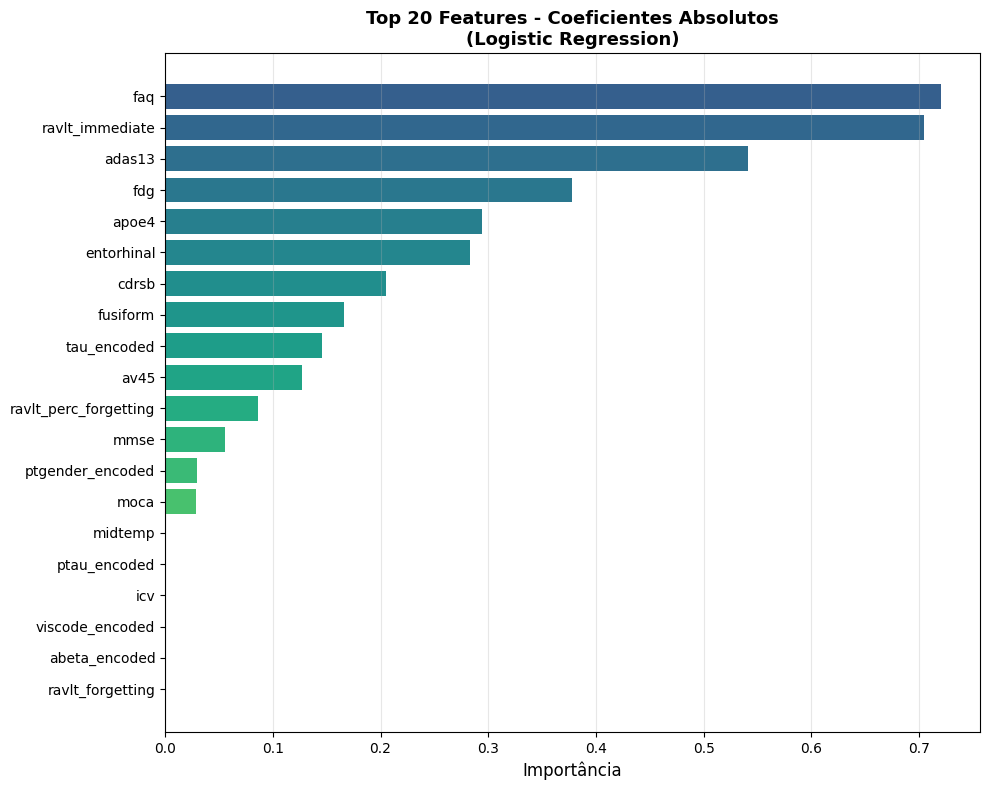


Interpretação: Features no topo têm maior impacto na predição de conversão MCI→Demência


In [ ]:
plt.figure(figsize=(10, 8))

colors = plt.cm.viridis(np.linspace(0.3, 0.9, 20))
plt.barh(range(20), feature_importance_df['Importance'], color=colors)
plt.yticks(range(20), feature_importance_df['Feature'], fontsize=10)
plt.xlabel('Importância', fontsize=12)

if hasattr(best_model, 'feature_importances_'):
    title = f' Features Mais Importantes\n({results_df['Model'].iloc[0]})'
elif hasattr(best_model, 'coef_'):
    title = f' Features - Coeficientes Absolutos\n({results_df['Model'].iloc[0]})'
else:
    title = ' Features Mais Importantes\n(Random Forest)'

plt.title(title, fontweight='bold', fontsize=13)
plt.gca().invert_yaxis()
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()



In [ ]:
models_dir = "../models/"
os.makedirs(models_dir, exist_ok=True)

for model_name, model in trained_models.items():
    filename = model_name.lower().replace(' ', '_') + '_optimized.pkl'
    filepath = os.path.join(models_dir, filename)
    
    with open(filepath, 'wb') as f:
        pickle.dump(model, f)
    
    print(f" {model_name} salvo em: {filepath}")

for model_name, bayes_obj in optimization_results.items():
    filename = model_name.lower().replace(' ', '_') + '_bayessearch.pkl'
    filepath = os.path.join(models_dir, filename)
    
    with open(filepath, 'wb') as f:
        pickle.dump(bayes_obj, f)
    
    print(f" {model_name} BayesSearchCV salvo em: {filepath}")

results_df.to_csv(os.path.join(models_dir, 'optimized_models_results.csv'), index=False)
print(f"\n Resultados salvos em: {os.path.join(models_dir, 'optimized_models_results.csv')}")

✓ Logistic Regression salvo em: ../models/logistic_regression_optimized.pkl
✓ Naive Bayes salvo em: ../models/naive_bayes_optimized.pkl
✓ Random Forest salvo em: ../models/random_forest_optimized.pkl
✓ SVM RBF salvo em: ../models/svm_rbf_optimized.pkl
✓ Logistic Regression BayesSearchCV salvo em: ../models/logistic_regression_bayessearch.pkl
✓ Random Forest BayesSearchCV salvo em: ../models/random_forest_bayessearch.pkl
✓ SVM RBF BayesSearchCV salvo em: ../models/svm_rbf_bayessearch.pkl

✓ Resultados salvos em: ../models/optimized_models_results.csv


Agora vou combinar todos os 4 modelos otimizados em um ensemble 

In [ ]:

ensemble = VotingClassifier(
    estimators=[
        ('logistic', trained_models['Logistic Regression']),
        ('naive_bayes', trained_models['Naive Bayes']),
        ('random_forest', trained_models['Random Forest']),
        ('svm', trained_models['SVM RBF'])
    ],
    voting='soft', 
    n_jobs=-1
)

print(f"Modelos incluídos: {len(ensemble.estimators)}")

ensemble.fit(X_train, y_train)


Criando Ensemble com Voting Classifier...
Modelos incluídos: 4
✓ Ensemble criado!



Vou ver se o ensemble é melhor que o melhor modelo individual.

In [ ]:
ensemble_cv_scores = cross_val_score(ensemble, X_train, y_train, cv=cv_strategy, scoring='roc_auc', n_jobs=-1)

print(f"\nEnsemble - ROC-AUC CV: {ensemble_cv_scores.mean():.4f} (±{ensemble_cv_scores.std():.4f})")

y_pred_ensemble_proba = ensemble.predict_proba(X_test)[:, 1]
y_pred_ensemble = ensemble.predict(X_test)

ensemble_test_roc_auc = roc_auc_score(y_test, y_pred_ensemble_proba)
ensemble_test_accuracy = accuracy_score(y_test, y_pred_ensemble)
ensemble_test_f1 = f1_score(y_test, y_pred_ensemble)

print(f"\nEnsemble ")
print(f"  ROC-AUC:   {ensemble_test_roc_auc:.4f}")
print(f"  Accuracy:  {ensemble_test_accuracy:.4f}")
print(f"  F1-Score:  {ensemble_test_f1:.4f}")

print("Ensemble vs Melhor Modelo Individual")
print(f"\n{results_df['Model'].iloc[0]}:")
print(f"  ROC-AUC CV:    {results_df['ROC-AUC_mean'].iloc[0]:.4f}")
print(f"  ROC-AUC Test:  {test_roc_auc:.4f}")

print(f"\nEnsemble :")
print(f"  ROC-AUC CV:    {ensemble_cv_scores.mean():.4f}")
print(f"  ROC-AUC Test:  {ensemble_test_roc_auc:.4f}")

improvement_cv = ensemble_cv_scores.mean() - results_df['ROC-AUC_mean'].iloc[0]
improvement_test = ensemble_test_roc_auc - test_roc_auc

print(f"\nMelhoria do Ensemble:")
print(f"  CV:   {improvement_cv:+.4f} ({improvement_cv*100:+.2f}%)")
print(f"  Test: {improvement_test:+.4f} ({improvement_test*100:+.2f}%)")

if improvement_test > 0.01 or improvement_cv > 0:
    print("\nEnsemble é MELHOR!")
else:
    print("\n Melhor usar só o modelo individual.")

Avaliando Ensemble com Cross-Validation...

Ensemble - ROC-AUC CV: 0.9065 (±0.0272)

Ensemble - Métricas no Teste:
  ROC-AUC:   0.8596
  Accuracy:  0.7647
  F1-Score:  0.6585

COMPARAÇÃO: Ensemble vs Melhor Modelo Individual

Logistic Regression:
  ROC-AUC CV:    0.9135
  ROC-AUC Test:  0.8692

Ensemble (todos os 4 modelos):
  ROC-AUC CV:    0.9065
  ROC-AUC Test:  0.8596

Melhoria do Ensemble:
  CV:   -0.0070 (-0.70%)
  Test: -0.0096 (-0.96%)

✗ Melhor usar só o modelo individual.


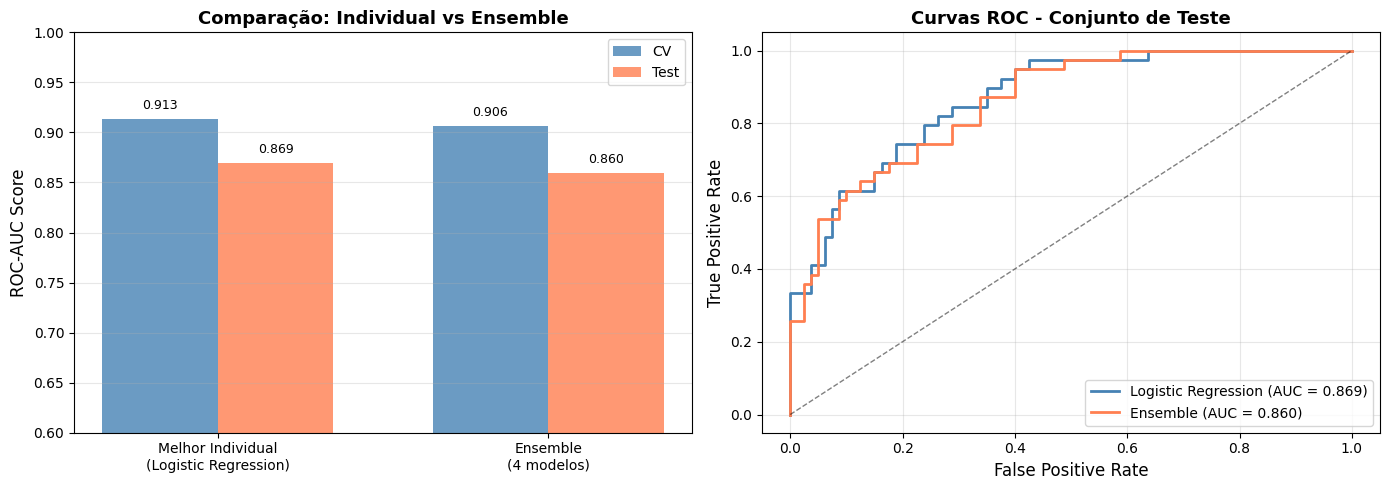

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

models_comparison = ['Melhor Individual\n(' + results_df['Model'].iloc[0] + ')', 'Ensemble\n(4 modelos)']
cv_scores = [results_df['ROC-AUC_mean'].iloc[0], ensemble_cv_scores.mean()]
test_scores = [test_roc_auc, ensemble_test_roc_auc]

x = np.arange(len(models_comparison))
width = 0.35

axes[0].bar(x - width/2, cv_scores, width, label='CV', color='steelblue', alpha=0.8)
axes[0].bar(x + width/2, test_scores, width, label='Test', color='coral', alpha=0.8)
axes[0].set_ylabel('ROC-AUC Score', fontsize=12)
axes[0].set_title('Comparação: Individual vs Ensemble', fontweight='bold', fontsize=13)
axes[0].set_xticks(x)
axes[0].set_xticklabels(models_comparison, fontsize=10)
axes[0].legend(fontsize=10)
axes[0].grid(axis='y', alpha=0.3)
axes[0].set_ylim([0.6, 1.0])

for i, (cv, test) in enumerate(zip(cv_scores, test_scores)):
    axes[0].text(i - width/2, cv + 0.01, f'{cv:.3f}', ha='center', fontsize=9)
    axes[0].text(i + width/2, test + 0.01, f'{test:.3f}', ha='center', fontsize=9)

fpr_best, tpr_best, _ = roc_curve(y_test, y_pred_proba)
fpr_ensemble, tpr_ensemble, _ = roc_curve(y_test, y_pred_ensemble_proba)

axes[1].plot(fpr_best, tpr_best, linewidth=2, 
             label=f'{results_df["Model"].iloc[0]} (AUC = {test_roc_auc:.3f})', color='steelblue')
axes[1].plot(fpr_ensemble, tpr_ensemble, linewidth=2, 
             label=f'Ensemble (AUC = {ensemble_test_roc_auc:.3f})', color='coral')
axes[1].plot([0, 1], [0, 1], 'k--', linewidth=1, alpha=0.5)
axes[1].set_xlabel('False Positive Rate', fontsize=12)
axes[1].set_ylabel('True Positive Rate', fontsize=12)
axes[1].set_title('Curvas ROC - Conjunto de Teste', fontweight='bold', fontsize=13)
axes[1].legend(fontsize=10)
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

In [ ]:
ensemble_filepath = os.path.join(models_dir, 'ensemble_voting_optimized.pkl')
with open(ensemble_filepath, 'wb') as f:
    pickle.dump(ensemble, f)

print(f" Ensemble salvo em: {ensemble_filepath}")

ensemble_results = {
    'Model': 'Ensemble (Voting)',
    'ROC-AUC_mean': ensemble_cv_scores.mean(),
    'ROC-AUC_std': ensemble_cv_scores.std(),
    'Accuracy_mean': ensemble_test_accuracy,
    'Accuracy_std': 0.0,
    'Precision_mean': precision_score(y_test, y_pred_ensemble),
    'Recall_mean': recall_score(y_test, y_pred_ensemble),
    'F1_mean': ensemble_test_f1,
    'Best_params': 'soft voting',
    'Training_time': 0.0  
}

results_with_ensemble = pd.concat([results_df, pd.DataFrame([ensemble_results])], ignore_index=True)
results_with_ensemble = results_with_ensemble.sort_values('ROC-AUC_mean', ascending=False).reset_index(drop=True)

print("RESULTADOS FINAIS: \n", results_with_ensemble[['Model', 'ROC-AUC_mean', 'Accuracy_mean', 'F1_mean']].to_string(index=False))


results_with_ensemble.to_csv(os.path.join(models_dir, 'final_results_with_ensemble.csv'), index=False)
print(f"\n Resultados finais salvos em: {os.path.join(models_dir, 'final_results_with_ensemble.csv')}")

✓ Ensemble salvo em: ../models/ensemble_voting_optimized.pkl

RESULTADOS FINAIS (incluindo Ensemble)
              Model  ROC-AUC_mean  Accuracy_mean  F1_mean
Logistic Regression      0.913490       0.819902 0.743321
            SVM RBF      0.913346       0.805009 0.730879
      Random Forest      0.911792       0.836879 0.732894
  Ensemble (Voting)      0.906478       0.764706 0.658537
        Naive Bayes      0.890543       0.777571 0.681749

✓ Resultados finais salvos em: ../models/final_results_with_ensemble.csv


In [ ]:


if 'ensemble_test_roc_auc' in locals() and ensemble_test_roc_auc > test_roc_auc:
    final_best = "Ensemble (Voting)"
    final_best_score = ensemble_test_roc_auc
    print(f"\n🏆 MELHOR SOLUÇÃO: Ensemble (combina os 4 modelos)")
else:
    final_best = results_df['Model'].iloc[0]
    final_best_score = test_roc_auc
    print(f"\n🏆 MELHOR SOLUÇÃO: {results_df['Model'].iloc[0]}")

print(f"ROC-AUC no teste: {final_best_score:.4f}")

if 'ensemble_test_roc_auc' in locals():
    print(f"\nComparação final:")
    print(f"  Melhor individual ({results_df['Model'].iloc[0]}): {test_roc_auc:.4f}")
    print(f"  Ensemble (4 modelos):                  {ensemble_test_roc_auc:.4f}")
    print(f"  Diferença:                              {ensemble_test_roc_auc - test_roc_auc:+.4f}")

print(f"\nTempo total de otimização: {results_df['Training_time'].sum():.1f}s ({results_df['Training_time'].sum()/60:.1f} min)")
print(f"\nModelos salvos em: {models_dir}")
print("  - Modelos otimizados (.pkl)")
print("  - Ensemble (.pkl)")
print("  - Objetos BayesSearchCV (pra análise de convergência)")
print("  - Tabela de resultados (.csv)")




RESUMO FINAL - MODELOS OTIMIZADOS + ENSEMBLE

🏆 MELHOR SOLUÇÃO: Logistic Regression
ROC-AUC no teste: 0.8692

Comparação final:
  Melhor individual (Logistic Regression): 0.8692
  Ensemble (4 modelos):                  0.8596
  Diferença:                              -0.0096

Tempo total de otimização: 337.7s (5.6 min)

Modelos salvos em: ../models/
  - Modelos otimizados (.pkl)
  - Ensemble (.pkl)
  - Objetos BayesSearchCV (pra análise de convergência)
  - Tabela de resultados (.csv)

